In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as st

## Simulacion

In [2]:
def modulacion(t,w,I0,phi): #Esta es una intensidad modulada con la misma frecuencia que el Lock-in
    return I0*np.sin(w*t+phi)

def iluminacion(A): #Esta intensidad nos da el numero esperado de fotones que llegan a la muestra
    return A
        
def ruidoPoiss(sig):# el ruido debido a los pocos fotones que llegan a la cámara
    #sig es la señal de entrada
    # A cada elemento se le mete un ruido correspondiente a lo que paso en ESE intervalo de tiempo.
    # Cada elemento en sig corresponde a la cantidad de fotones originales en un intervalo de tiempo determinado
    yP = []
    for i in range(len(sig)):
        yP.append(sig[i] + np.sign(np.random.normal(0,scale = 1))*np.random.poisson(lam=abs(sig[i])))
    return yP

def ruidoLec(sig,sigma):
    yL = []
    for i in range(len(sig)):
        yL.append(sig[i] + np.random.normal(0, scale = sigma))
    return yL

In [3]:
#definicion de Delta F/F0

def porcentaje(señal):
    prom = np.mean(señal)
    num = abs(señal-prom)
    return num/prom

In [4]:
#creación de a funcion señal original:
def señal(x):
    y = []
    for i in range(len(x)):
        if x[i]<50:
            y.append(np.random.normal(0,0.01))
        elif x[i]>50 and x[i]<60:
            y.append(((x[i]+50)/50)**2)
        elif x[i]>60 and x[i]<70:
            y.append(100*((50-x[i])/50)**2)
        elif x[i]>70 and x[i]<100:
            y.append(np.random.normal(0,0.02))
        else:
            y.append(9*np.cos(0.05*x[i])**2)
    y = np.array(y)
    x = np.array(x)
    return y

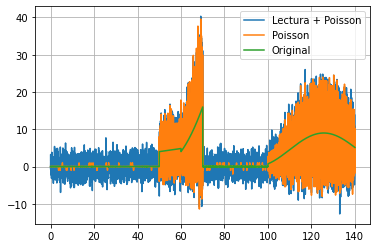

In [5]:
# Añadimos el ruido a la señal original 'y'
N = 7000 #numero de dato tomadas
dt = 1/50 #intervalo de tiempo para tomar cada dato
x = np.linspace(0,dt*N,N)
y = señal(x)
promedio = np.mean(y)
yP = ruidoPoiss(y)
yL = ruidoLec(yP,2)
Y = [y,yP,yL]
plt.plot(x,yL,label = 'Lectura + Poisson')
plt.plot(x,yP, label = 'Poisson')
plt.plot(x,y, label = 'Original')
plt.grid()
plt.legend()

Text(0.5, 1.0, '$\\Delta F/F_0$')

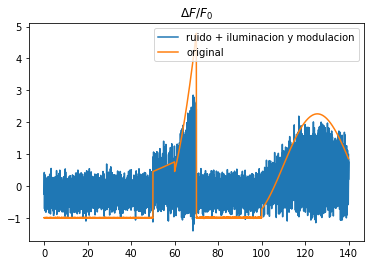

In [78]:
#Incluimos intensidad de ilumnación y modulación
Amp = 10
I0 = 0.5*Amp
frecuencia = 30
yFinal = yL+ modulacion(x,frecuencia,I0,0) + iluminacion(Amp)
promedio2 = np.mean(yFinal)
cambioY = (y-promedio)/promedio
cambioYFinal = (yFinal-promedio2)/promedio2
    

plt.plot(x,cambioYFinal,label='ruido + iluminacion y modulacion')
plt.plot(x,cambioY, label = 'original')
plt.legend()
plt.title(r'$\Delta F/F_0$')

## Lock In

In [79]:
from scipy import signal
import scipy as sp

In [80]:
## Filtro Pasabajas
fs = 1/dt
fc = 0.005*frecuencia
w = fc/(fs/2)

b, a = signal.butter(5,w,'low',analog = False)
z, p = signal.bilinear(b,a,fs)
# w is the freq in z-domain & h is the magnitude in z-domain
w, h = signal.freqz(z, p, 512)

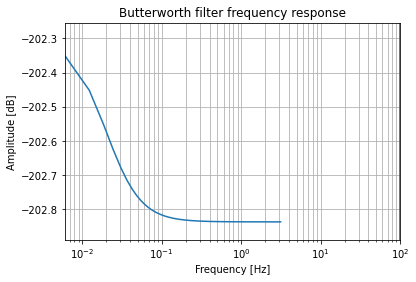

In [81]:
# Magnitude Response
plt.semilogx(w, 20*np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green')
plt.show()

In [82]:
## Lock in:

# señales de referencia
def referencia(w,t):
    t = np.array(t)
    y1 = np.cos(w*t)
    y2 = np.sin(w*t)
    return [y1,y2]


#Multiplicaciones 

def multiplicacion1(signal,referencia):
    referencia = np.array(referencia[0])
    signal = np.array(signal)
    uno = referencia*signal
    return uno

def multiplicacion2(signal,referencia):
    referencia = np.array(referencia[1])
    signal = np.array(signal)
    dos = referencia*signal
    return dos

X = filtered_signal = sp.signal.filtfilt(b, a, multiplicacion1(yFinal,referencia(frecuencia,x)[0]))
Y = filtered_signal = sp.signal.filtfilt(b, a, multiplicacion2(yFinal,referencia(frecuencia,x)[1]))

#Cuadraturas
X = np.array(X)
Y = np.array(Y)


#Amplitud 
A = 2*np.sqrt(np.square(X)+np.square(Y))


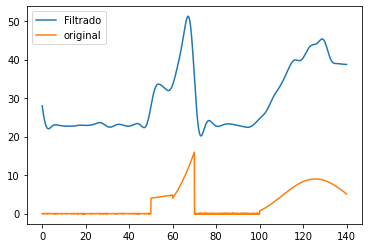

In [83]:

plt.plot(x,A, label = 'Filtrado') #Al resultado le quitamos 
#la iluminacion y modulacion con el fin de comparar con los datos original
plt.plot(x,y, label = 'original')
plt.legend()

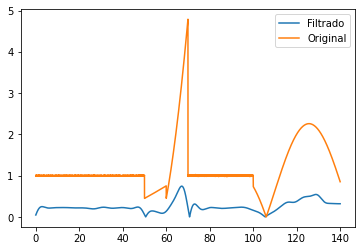

In [84]:
plt.plot(x,porcentaje(A),label = 'Filtrado')
plt.plot(x,porcentaje(y),label = 'Original')
plt.legend()

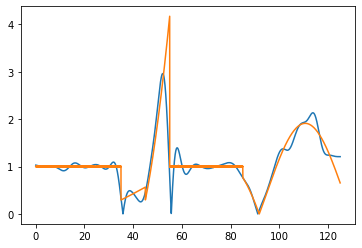

In [86]:
x1 = []
y1 = []
filtrado = []
for i in range(len(x)):
    if x[i]>15:
        x1.append(x[i]-15)
        y1.append(y[i])
        filtrado.append(A[i]-23)

plt.plot(x1,porcentaje(filtrado))
plt.plot(x1,porcentaje(y1))